In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


In [4]:
# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
train_df = pd.read_csv("./archive/train_data.csv")
test_df = pd.read_csv("./archive/test_data.csv")
weekly_forecast_df = pd.read_csv("./archive/weekly pre-dispatch forecast.csv")

# 2. ÎÇ†Ïßú ÌòïÏãù Î≥ÄÌôò
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])
weekly_forecast_df["datetime"] = pd.to_datetime(weekly_forecast_df["datetime"], format="%m/%d/%Y %H:%M") ## Ïó¨Í∏∞ÏÑú Ïú†ÎãâÏä§ÌÉÄÏûÑÏúºÎ°ú Î≥ÄÍ≤Ω

In [5]:
# 3. Ï£ºÍ∞Ñ ÏòàÏ∏° Îç∞Ïù¥ÌÑ∞ÏôÄ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î•º Î≥ëÌï©
merged_df = test_df.merge(weekly_forecast_df, on="datetime", how="left")

## ÌÖåÏä§Ìä∏Îç∞Ïù¥ÌÑ∞ÏôÄ Îî∞Î°ú Î≥¥ÏïÑÏïºÌï® Î≥ëÌï© Î∂àÌïÑÏöî

In [6]:
# 4. ÏÇ¨Ï†Ñ ÏòàÏ∏° ÏÑ±Îä• ÌèâÍ∞Ä
mae_official = mean_absolute_error(merged_df["DEMAND"], merged_df["load_forecast"])
rmse_official = np.sqrt(mean_squared_error(merged_df["DEMAND"], merged_df["load_forecast"]))

print(f"Pre-dispatch (ÏÇ¨Ï†Ñ ÏòàÏ∏°) - MAE: {mae_official:.2f}, RMSE: {rmse_official:.2f}")


Official Forecast (Í≥µÏãù ÏòàÏ∏°) - MAE: 59.20, RMSE: 74.03


In [7]:
# 5. XGBoost ÏòàÏ∏° Î™®Îç∏ Íµ¨Ï∂ï
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", 
            "weekend", "holiday", "Holiday_ID", "hourOfDay", "T2M_toc"]
target = "DEMAND"

X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
# 6. Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÏÑ±Îä• ÌèâÍ∞Ä
y_pred_xgb = xgb_model.predict(X_valid)
mae_xgb = mean_absolute_error(y_valid, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f"XGBoost Validation (XGBoost Î™®Îç∏ Í≤ÄÏ¶ù ÏÑ±Îä•) - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


XGBoost Validation (XGBoost Î™®Îç∏ Í≤ÄÏ¶ù ÏÑ±Îä•) - MAE: 37.98, RMSE: 50.95


In [9]:
# 7. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Î∞è ÏÑ±Îä• ÎπÑÍµê
test_df["xgb_pred"] = xgb_model.predict(test_df[features])

mae_xgb_test = mean_absolute_error(test_df["DEMAND"], test_df["xgb_pred"])
rmse_xgb_test = np.sqrt(mean_squared_error(test_df["DEMAND"], test_df["xgb_pred"]))

print(f"XGBoost Test - MAE: {mae_xgb_test:.2f}, RMSE: {rmse_xgb_test:.2f}")

XGBoost Test - MAE: 43.63, RMSE: 54.66


In [12]:
# 8. ÎπÑÍµê Í≤∞Í≥º Ï∂úÎ†•
print("ÏÑ±Îä• ÎπÑÍµê:")
print(f"ÏÇ¨Ï†Ñ ÏòàÏ∏° - MAE: {mae_official:.2f}, RMSE: {rmse_official:.2f}")
print(f"XGBoost Model - MAE: {mae_xgb_test:.2f}, RMSE: {rmse_xgb_test:.2f}")

ÏÑ±Îä• ÎπÑÍµê:
Í≥µÏãù ÏòàÏ∏° - MAE: 59.20, RMSE: 74.03
XGBoost Model - MAE: 43.63, RMSE: 54.66


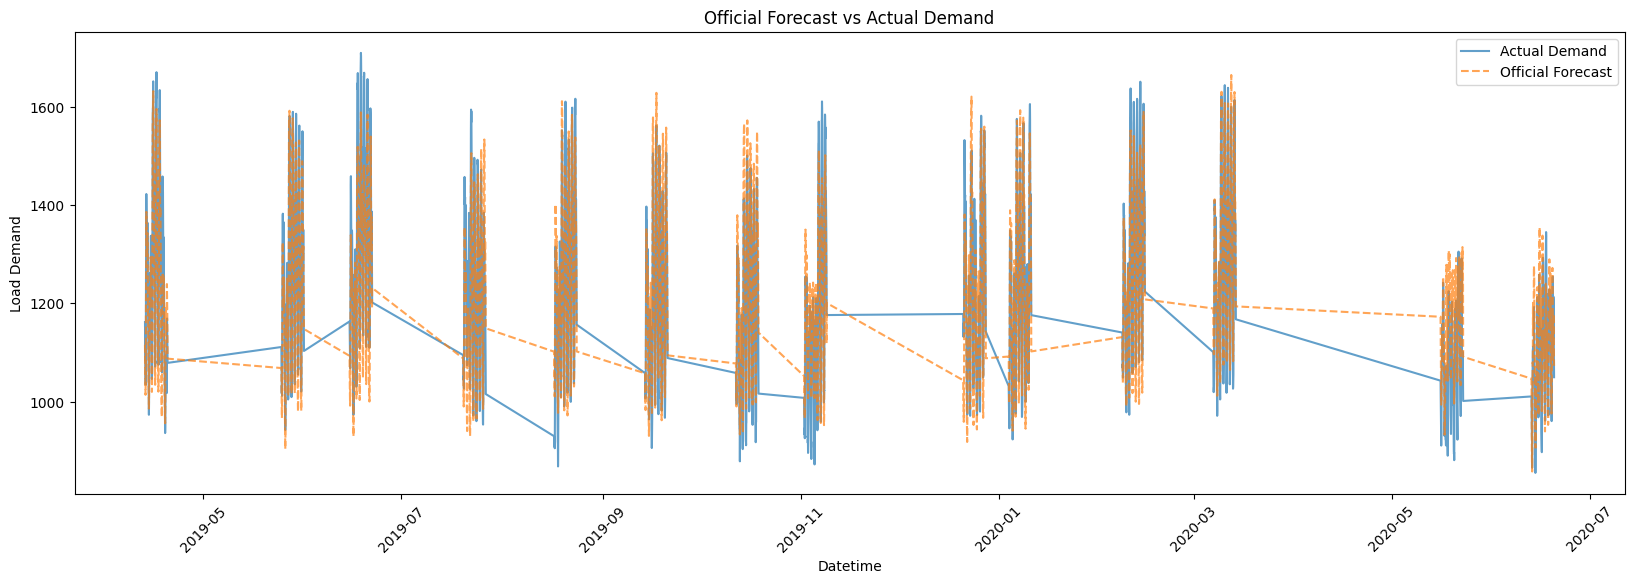

In [10]:
import matplotlib.pyplot as plt
import numpy as np

#  1. ÏÇ¨Ï†Ñ ÏòàÏ∏° vs Ïã§Ï†ú Î∂ÄÌïò ÎπÑÍµê ÏãúÍ∞ÅÌôî (ÏãúÍ∞ÑÏóê Îî∞Î•∏ Î≥ÄÌôî)
plt.figure(figsize=(20, 6))
plt.plot(merged_df["datetime"], merged_df["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(merged_df["datetime"], merged_df["load_forecast"], label="Official Forecast", linestyle="--", alpha=0.7)
plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("Official Forecast vs Actual Demand")
plt.legend()
plt.xticks(rotation=45)
plt.show()


xÏ∂ï ÏÑ§Ï†ï ÏûòÎ™ªÎêúÎìØ -> Îã¨Ïù¥ ÎÑòÏñ¥Í∞àÎïå 0731 ~ 0801 Ïù¥Îïå Í≥µÎ∞±ÏÉùÍπÄ
Ïú†ÎãâÏä§ ÏãúÍ∞ÑÏúºÎ°ú Ï†ïÏàòÎ°ú Ï∑®Í∏âÌï¥ÏÑú ÎÇòÌÉÄÎÇ¥ÏïºÌï®
ÌååÏù¥Ïç¨ datetime time
ÌïúÏãúÍ∞Ñ Îã®ÏúÑÎ°ú Î≥ÄÍ≤Ω
ÎÇ†ÏßúÎ•º Ïú†ÎãâÏä§ ÏãúÍ∞ÑÏúºÎ°ú Î∞îÍæ∏Îäî Ï†ÑÏ≤òÎ¶¨ ÌïÑÏöî, ÏãúÍ∞ÅÌôîÌï†Îïê Ïú†ÎãâÏä§ÏãúÍ∞Ñ Î≥ÄÌôòÌï¥ÏÑú Ïã§Ï†ú ÎÇ†ÏßúÎ°ú ÌëúÍ∏∞ÌïòÍ∏∞

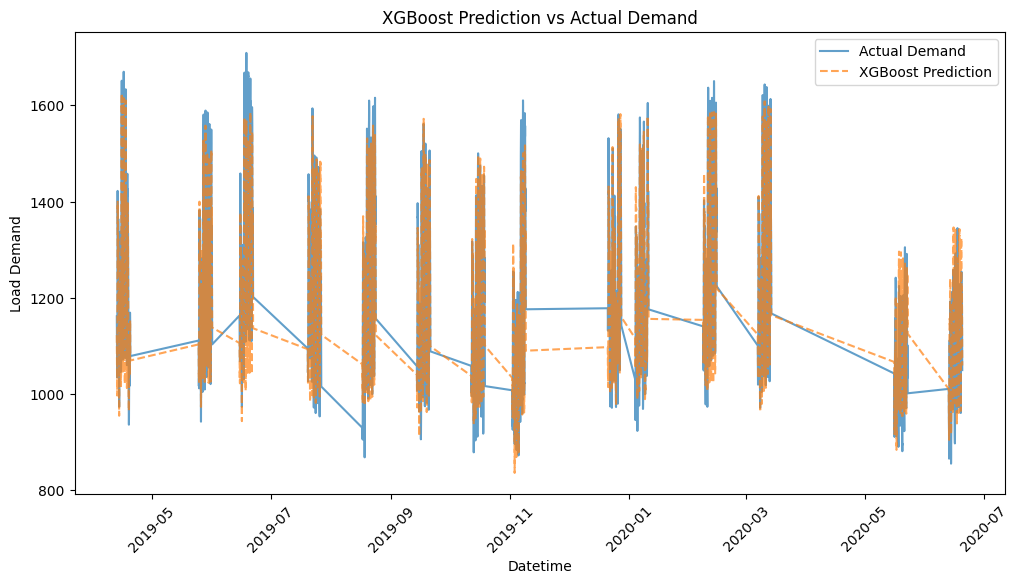

In [14]:
#  2. XGBoost ÏòàÏ∏° vs Ïã§Ï†ú Î∂ÄÌïò ÎπÑÍµê (ÏãúÍ∞ÑÏóê Îî∞Î•∏ Î≥ÄÌôî)
plt.figure(figsize=(12, 6))
plt.plot(test_df["datetime"], test_df["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(test_df["datetime"], test_df["xgb_pred"], label="XGBoost Prediction", linestyle="--", alpha=0.7)
plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("XGBoost Prediction vs Actual Demand")
plt.legend()
plt.xticks(rotation=45)
plt.show()


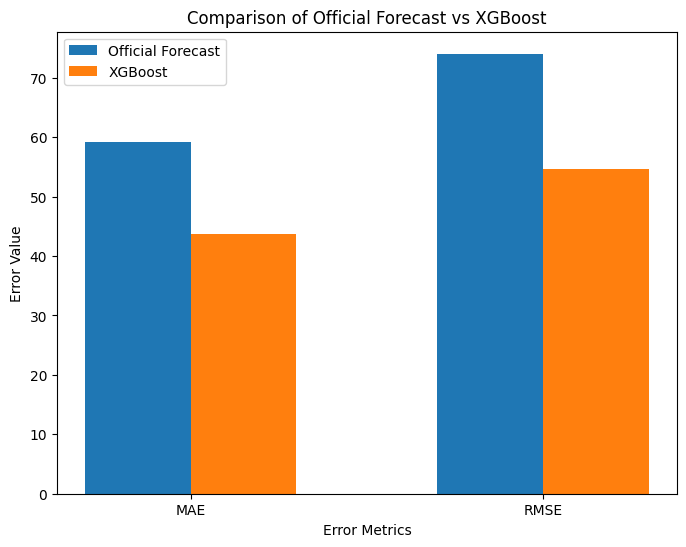

In [15]:
#  3. Î™®Îç∏Î≥Ñ Ïò§Ï∞® ÎπÑÍµê (MAE, RMSE)
metrics = ["MAE", "RMSE"]
official_errors = [mae_official, rmse_official]
xgb_errors = [mae_xgb_test, rmse_xgb_test]

plt.figure(figsize=(8, 6))
x = np.arange(len(metrics))
width = 0.3

plt.bar(x - width/2, official_errors, width, label="Official Forecast")
plt.bar(x + width/2, xgb_errors, width, label="XGBoost")

plt.xlabel("Error Metrics")
plt.ylabel("Error Value")
plt.title("Comparison of Official Forecast vs XGBoost")
plt.xticks(ticks=x, labels=metrics)
plt.legend()
plt.show()

ÎÖºÎ¨∏Ïóê Evaluation metrics Îã§ Ìï¥Î≥¥Í≥† Ïù¥Í≤®Î≥¥Í∏∞

üõëüõëüõë ÏÑ±Îä• Í∞úÏÑ†ÏúÑÌï¥ üõëüõëüõë

(1) ÏãúÍ∞ÑÎåÄÎ≥Ñ Ïò§Ï∞® Î∂ÑÏÑù -> ÌîºÌÅ¨ ÌÉÄÏûÑ (Ï∂úÌá¥Í∑ºÏãúÍ∞Ñ) Î≥ÄÏàò Ï∂îÍ∞Ä
(2) Í≥ÑÏ†à Î≥ÄÏàò Ï∂îÍ∞Ä (Ïó¨Î¶ÑÏ≤†, Í≤®Ïö∏Ï≤† Ï†ÑÎ†• ÏÇ¨Ïö©Îüâ Ï¶ùÍ∞ÄÏóê Îî∞Î¶Ñ)
(3) ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù

(1),(2)

In [16]:
import pandas as pd

#  Îç∞Ïù¥ÌÑ∞ Î°úÎî©
train_df = pd.read_csv("./archive/train_data.csv")
test_df = pd.read_csv("./archive/test_data.csv")

#  datetime Ïª¨Îüº Î≥ÄÌôò
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

# (1) ÌîºÌÅ¨ÌÉÄÏûÑ Î≥ÄÏàò Ï∂îÍ∞Ä (Ï∂úÌá¥Í∑º ÏãúÍ∞Ñ: 07:00-09:00, 17:00-20:00)
def define_peak_time(hour):
    return 1 if (7 <= hour <= 9) or (17 <= hour <= 20) else 0

train_df["peak_time"] = train_df["hourOfDay"].apply(define_peak_time)
test_df["peak_time"] = test_df["hourOfDay"].apply(define_peak_time)

# (2) Í≥ÑÏ†à Î≥ÄÏàò Ï∂îÍ∞Ä (Î¥Ñ=0, Ïó¨Î¶Ñ=1, Í∞ÄÏùÑ=2, Í≤®Ïö∏=3)
def define_season(month):
    if month in [3, 4, 5]:  # Î¥Ñ
        return 0
    elif month in [6, 7, 8]:  # Ïó¨Î¶Ñ
        return 1
    elif month in [9, 10, 11]:  # Í∞ÄÏùÑ
        return 2
    else:  # Í≤®Ïö∏ (12, 1, 2)
        return 3

train_df["season"] = train_df["datetime"].dt.month.apply(define_season)
test_df["season"] = test_df["datetime"].dt.month.apply(define_season)

#  Î≥ÄÏàòÍ∞Ä Ï∂îÍ∞ÄÎêú Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
print(train_df[["datetime", "hourOfDay", "peak_time", "season"]].head())
print(test_df[["datetime", "hourOfDay", "peak_time", "season"]].head())

#  ÏÉàÎ°úÏö¥ Î≥ÄÏàò Ìè¨Ìï®ÌïòÏó¨ Ï†ÄÏû•
train_df.to_csv("./archive/train_data_processed.csv", index=False)
test_df.to_csv("./archive/test_data_processed.csv", index=False)


             datetime  hourOfDay  peak_time  season
0 2015-01-31 01:00:00          1          0       3
1 2015-01-31 02:00:00          2          0       3
2 2015-01-31 03:00:00          3          0       3
3 2015-01-31 04:00:00          4          0       3
4 2015-01-31 05:00:00          5          0       3
             datetime  hourOfDay  peak_time  season
0 2019-04-13 01:00:00          1          0       0
1 2019-04-13 02:00:00          2          0       0
2 2019-04-13 03:00:00          3          0       0
3 2019-04-13 04:00:00          4          0       0
4 2019-04-13 05:00:00          5          0       0


holiday Îäî Ï∂úÌá¥Í∑º Î≥ÄÏàò Í¥ÄÏó¨x

train_data_processed.csv
test_data_processed.csv 
Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Îì§ Ï†ÄÏû•

(3) ÌïòÏù¥Ìçº ÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù

## ÎÖºÎ¨∏Ïùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ 

In [4]:
## GridSearchCV ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

#  Îç∞Ïù¥ÌÑ∞ Î°úÎî©
train_df = pd.read_csv("./archive/train_data_processed.csv")

#  ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü ÏÑ§Ï†ï
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday",
            "Holiday_ID", "hourOfDay", "T2M_toc", "peak_time", "season"]
target = "DEMAND"

#  ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

#  XGBoost Î™®Îç∏ Ï†ïÏùò
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)  ## random state = 123

#  ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌÉêÏÉâ Í≥µÍ∞Ñ Ï†ïÏùò
param_grid = {
    "n_estimators": [100, 200, 300],  # Ìä∏Î¶¨ Í∞úÏàò
    "learning_rate": [0.01, 0.05, 0.1],  # ÌïôÏäµÎ•†
    "max_depth": [3, 5, 7],  # Ìä∏Î¶¨ ÍπäÏù¥
    "subsample": [0.8, 1.0],  # Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ ÎπÑÏú®
    "colsample_bytree": [0.8, 1.0],  # ÌîºÏ≤ò ÏÉòÌîåÎßÅ ÎπÑÏú®
}

#  GridSearchCV Ïã§Ìñâ (5-fold cross validation)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error", verbose=2, n_jobs=-1) ## scoring ÏùÑ rmseÎ°ú
grid_search.fit(X_train, y_train)

#  ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï∂úÎ†•
print("‚úÖ ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞:", grid_search.best_params_)

#  ÏµúÏ†Å Î™®Îç∏ ÏÑ±Îä• ÌèâÍ∞Ä
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_valid)

mae_xgb_tuned = mean_absolute_error(y_valid, y_pred_xgb)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f"‚úÖ ÏµúÏ†Å XGBoost Î™®Îç∏ ÏÑ±Îä• (GridSearch ÌäúÎãù ÌõÑ)")
print(f"MAE: {mae_xgb_tuned:.2f}")
print(f"RMSE: {rmse_xgb_tuned:.2f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.2s
[CV] END 

In [5]:
import pandas as pd

#  ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
test_df = pd.read_csv("./archive/test_data_processed.csv")

#  ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÏòàÏ∏° ÏàòÌñâ
y_test_pred_xgb = best_xgb.predict(test_df[features])

#  ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏÑ±Îä• ÌèâÍ∞Ä
mae_xgb_test = mean_absolute_error(test_df["DEMAND"], y_test_pred_xgb)
rmse_xgb_test = np.sqrt(mean_squared_error(test_df["DEMAND"], y_test_pred_xgb))

print(f"‚úÖ ÏµúÏ†Å XGBoost Î™®Îç∏ ÏÑ±Îä• (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞)")
print(f"MAE (ÌÖåÏä§Ìä∏): {mae_xgb_test:.2f}")
print(f"RMSE (ÌÖåÏä§Ìä∏): {rmse_xgb_test:.2f}")


‚úÖ ÏµúÏ†Å XGBoost Î™®Îç∏ ÏÑ±Îä• (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞)
MAE (ÌÖåÏä§Ìä∏): 33.67
RMSE (ÌÖåÏä§Ìä∏): 44.15


In [18]:
# Optuna ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù

import optuna
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

#  Îç∞Ïù¥ÌÑ∞ Î°úÎî©
train_df = pd.read_csv("./archive/train_data_processed.csv")

#  ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü ÏÑ§Ï†ï
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday",
            "Holiday_ID", "hourOfDay", "T2M_toc", "peak_time", "season"]
target = "DEMAND"

#  ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
# X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

#  Optuna ÏµúÏ†ÅÌôî Ìï®Ïàò
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    }
    
    model = XGBRegressor(**params, objective="reg:squarederror", random_state=42)  ## randomstate 123ÏúºÎ°ú
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

#  Optuna Ïã§Ìñâ (30Î≤à Î∞òÎ≥µ ÌÉêÏÉâ)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

#  ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï∂úÎ†•
print("‚úÖ ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞:", study.best_params)

#  ÏµúÏ†Å Î™®Îç∏Î°ú ÏÑ±Îä• ÌèâÍ∞Ä
best_xgb = XGBRegressor(**study.best_params, objective="reg:squarederror", random_state=42) ## random state = 123
best_xgb.fit(X_train, y_train)

y_pred_xgb = best_xgb.predict(X_valid)

mae_xgb_optuna = mean_absolute_error(y_valid, y_pred_xgb)
rmse_xgb_optuna = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f"‚úÖ Optuna ÏµúÏ†Å XGBoost Î™®Îç∏ ÏÑ±Îä•")
print(f"MAE: {mae_xgb_optuna:.2f}")
print(f"RMSE: {rmse_xgb_optuna:.2f}")


/Users/jeonjunhyeok/Desktop/Lab/ML/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-07 22:16:42,155] A new study created in memory with name: no-name-766c3e91-9f90-4aa9-b537-72e2d4a80063
/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_33977/3350768654.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
[I 2025-03-07 22:16:45,831] Trial 0 finished with value: 28.67833344137286 and parameters: {'n_estimators': 350, 'learning_rate': 0.04921447552831815, 'max_depth': 8, 'subsample': 0.916816499305352, 'colsample_bytree': 0.6306656449963194}. Best is tri

‚úÖ ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {'n_estimators': 300, 'learning_rate': 0.19990783912032414, 'max_depth': 10, 'subsample': 0.6838258589913246, 'colsample_bytree': 0.8283144331909364}
‚úÖ Optuna ÏµúÏ†Å XGBoost Î™®Îç∏ ÏÑ±Îä•
MAE: 7.02
RMSE: 11.02


optuna Ïó¨Îü¨Î≤àÌï¥ÏïºÌï® ÏÑúÎ°úÎã§Î•∏ seedÎ°ú 20~30Ìöå Ïã§Ìñâ -> Îã§Î•∏Î∞©Î≤ïÍ≥º ÎπÑÍµê(t-test)
one-sample t-test, paired t-test
--> t-test ÌïòÎ©¥ p-value ÎÇòÏò§ÎäîÎç∞ 0.05 Î≥¥Îã§ ÏûëÍ≤åÎÇòÏò§Î©¥ Ï∞®Ïù¥Í∞Ä Ïú†ÏùòÎØ∏
box plot Î∞ïÏä§ÌîåÎ°Ø

In [19]:
#  ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎî©
test_df = pd.read_csv("./archive/test_data_processed.csv")

#  Optuna ÏµúÏ†Å Î™®Îç∏Î°ú ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°
test_df["xgb_optuna_pred"] = best_xgb.predict(test_df[features])

#  ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏÑ±Îä• ÌèâÍ∞Ä
mae_xgb_test = mean_absolute_error(test_df["DEMAND"], test_df["xgb_optuna_pred"])
rmse_xgb_test = np.sqrt(mean_squared_error(test_df["DEMAND"], test_df["xgb_optuna_pred"]))

print(f"‚úÖ Optuna ÏµúÏ†Å Î™®Îç∏ ÏÑ±Îä• (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞)")
print(f"MAE (ÌÖåÏä§Ìä∏): {mae_xgb_test:.2f}")
print(f"RMSE (ÌÖåÏä§Ìä∏): {rmse_xgb_test:.2f}")


‚úÖ Optuna ÏµúÏ†Å Î™®Îç∏ ÏÑ±Îä• (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞)
MAE (ÌÖåÏä§Ìä∏): 14.59
RMSE (ÌÖåÏä§Ìä∏): 26.29


üõë Optuna ÏóêÏÑú ÎÑàÎ¨¥ Í≥ºÎèÑÌïòÍ≤å Ï¢ãÏùÄ ÏÑ±Îä•Ïù¥ ÎÇòÏò®Í≤ÉÏúºÎ°ú Î≥¥ÏïÑ Í≥ºÏ†ÅÌï© Î¨∏Ï†úÍ∞Ä ÏùºÏñ¥ÎÇúÎìØ ÌïòÏó¨
max_depth Í∞êÏÜå, learning_rate Í∞êÏÜå, Ï†ïÍ∑úÌôî Ï∂îÍ∞ÄÎ•º ÏßÑÌñâÌïòÏó¨
Í≥ºÏ†ÅÌï© Ìï¥Í≤∞ ÏãúÎèÑ

In [18]:
import optuna
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


#  Îç∞Ïù¥ÌÑ∞ Î°úÎî©
train_df = pd.read_csv("./archive/train_data_processed.csv")

#  ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü ÏÑ§Ï†ï
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday",
            "Holiday_ID", "hourOfDay", "T2M_toc", "peak_time", "season"]
target = "DEMAND"

#  ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

#  Optuna ÏµúÏ†ÅÌôî Ìï®Ïàò
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),  # ÌïôÏäµÎ•† 0.2 -> 0.15 Í∞êÏÜå
        "max_depth": trial.suggest_int("max_depth", 5, 7),                            # 10ÏóêÏÑú 5, 7 Î°ú Í∞êÏÜå
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),  # Ï†ïÍ∑úÌôî Ï∂îÍ∞Ä
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),  # Ï†ïÍ∑úÌôî Ï∂îÍ∞Ä
    }
    
    model = XGBRegressor(**params, objective="reg:squarederror", random_state=42)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

####  Optuna Ïã§Ìñâ (30Î≤à Î∞òÎ≥µ ÌÉêÏÉâ)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

#  ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï∂úÎ†•
print("‚úÖ Í≥ºÏ†ÅÌï© Ìï¥Í≤∞ÏùÑ ÏúÑÌïú ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞:", study.best_params)

#  ÏµúÏ†Å Î™®Îç∏Î°ú ÏÑ±Îä• ÌèâÍ∞Ä
best_xgb = XGBRegressor(**study.best_params, objective="reg:squarederror", random_state=42)
best_xgb.fit(X_train, y_train)

y_pred_xgb = best_xgb.predict(X_valid)

mae_xgb_optuna_fixed = mean_absolute_error(y_valid, y_pred_xgb)
rmse_xgb_optuna_fixed = np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

print(f"‚úÖ Í≥ºÏ†ÅÌï© Ìï¥Í≤∞ ÌõÑ ÏµúÏ†Å XGBoost Î™®Îç∏ ÏÑ±Îä•")
print(f"MAE: {mae_xgb_optuna_fixed:.2f}")
print(f"RMSE: {rmse_xgb_optuna_fixed:.2f}")


/Users/jeonjunhyeok/Desktop/Lab/ML/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-17 13:17:17,856] A new study created in memory with name: no-name-e8d7c95c-aecd-42ad-bd4e-1f190da1431a
[I 2025-03-17 13:17:20,774] Trial 0 finished with value: 32.73835718002497 and parameters: {'n_estimators': 350, 'learning_rate': 0.06295009681166752, 'max_depth': 6, 'subsample': 0.8981859019913456, 'colsample_bytree': 0.9489525315396039, 'reg_lambda': 0.005792272061630845, 'reg_alpha': 0.018520082030985575}. Best is trial 0 with value: 32.73835718002497.
[I 2025-03-17 13:17:23,460] Trial 1 finished with value: 36.14274791902355 and parameters: {'n_estimators': 400, 'learning_rate': 0.032944719635260626, 'max_depth': 5, 'subsample': 0.8522289350502376, 'colsample_bytree': 0.8310583674332183, 'reg_lambda'

‚úÖ Í≥ºÏ†ÅÌï© Ìï¥Í≤∞ÏùÑ ÏúÑÌïú ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {'n_estimators': 500, 'learning_rate': 0.14744502513599717, 'max_depth': 7, 'subsample': 0.7064985406961457, 'colsample_bytree': 0.8059510389053872, 'reg_lambda': 0.02987086912798745, 'reg_alpha': 0.0010256366199095327}
‚úÖ Í≥ºÏ†ÅÌï© Ìï¥Í≤∞ ÌõÑ ÏµúÏ†Å XGBoost Î™®Îç∏ ÏÑ±Îä•
MAE: 21.70
RMSE: 29.13


In [19]:
#  ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î°úÎî©
test_df = pd.read_csv("./archive/test_data_processed.csv")

#  Í≥ºÏ†ÅÌï© Ìï¥Í≤∞Îêú ÏµúÏ†Å Î™®Îç∏Î°ú ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°
test_df["xgb_optuna_fixed_pred"] = best_xgb.predict(test_df[features])

#  ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏÑ±Îä• ÌèâÍ∞Ä
mae_xgb_test_fixed = mean_absolute_error(test_df["DEMAND"], test_df["xgb_optuna_fixed_pred"])
rmse_xgb_test_fixed = np.sqrt(mean_squared_error(test_df["DEMAND"], test_df["xgb_optuna_fixed_pred"]))

print(f"‚úÖ Í≥ºÏ†ÅÌï© Ìï¥Í≤∞ ÌõÑ ÏµúÏ†Å Î™®Îç∏ ÏÑ±Îä• (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞)")
print(f"MAE (ÌÖåÏä§Ìä∏): {mae_xgb_test_fixed:.2f}")
print(f"RMSE (ÌÖåÏä§Ìä∏): {rmse_xgb_test_fixed:.2f}")


‚úÖ Í≥ºÏ†ÅÌï© Ìï¥Í≤∞ ÌõÑ ÏµúÏ†Å Î™®Îç∏ ÏÑ±Îä• (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞)
MAE (ÌÖåÏä§Ìä∏): 28.24
RMSE (ÌÖåÏä§Ìä∏): 38.85


ÏÑ±Îä• ÎπÑÍµê:
Í≥µÏãù ÏòàÏ∏° - MAE: 59.20, RMSE: 74.03
XGBoost Model - MAE: 43.63, RMSE: 54.66
GridSearch ÌäúÎãù - MAE : 33.67, RMSE : 44.15
Optuna ÌäúÎãù - MAE: 30.36, RMSE: 40.70

In [20]:
import joblib

#  ÏµúÏ†Å Î™®Îç∏ Ï†ÄÏû•
joblib.dump(best_xgb, "./archive/final_xgb_model.pkl")
print("ÏµúÏ¢Ö Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å! (./archive/final_xgb_model.pkl)")


ÏµúÏ¢Ö Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å! (./archive/final_xgb_model.pkl)


In [21]:
# üîπ ÏµúÏ¢Ö ÏòàÏ∏° Í≤∞Í≥º CSV Ï†ÄÏû•
test_df[["datetime", "DEMAND", "xgb_optuna_fixed_pred"]].to_csv("./archive/final_predictions.csv", index=False)
print("ÏµúÏ¢Ö ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû• ÏôÑÎ£å! (./archive/final_predictions.csv)")


ÏµúÏ¢Ö ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû• ÏôÑÎ£å! (./archive/final_predictions.csv)


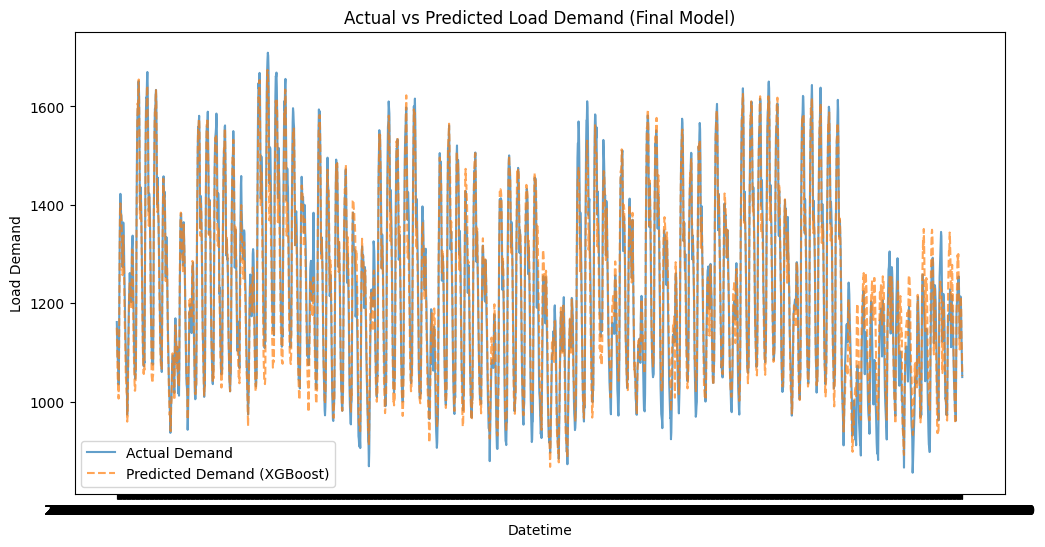

In [30]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

#  Ï†ÄÏû•Îêú Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
test_df = pd.read_csv("./archive/final_predictions.csv")

#  Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
best_xgb = joblib.load("./archive/final_xgb_model.pkl")


#  ÏãúÍ∞ÅÌôî: Ïã§Ï†ú Î∂ÄÌïò vs ÏµúÏ¢Ö ÏòàÏ∏°Í∞í ÎπÑÍµê (ÏãúÍ∞Ñ ÌùêÎ¶ÑÏóê Îî∞Î•∏ Î≥ÄÌôî)
plt.figure(figsize=(12, 6))
plt.plot(test_df["datetime"], test_df["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(test_df["datetime"], test_df["xgb_optuna_fixed_pred"], label="Predicted Demand (XGBoost)", linestyle="--", alpha=0.7)
plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("Actual vs Predicted Load Demand (Final Model)")
plt.legend()
plt.xticks()
plt.show()


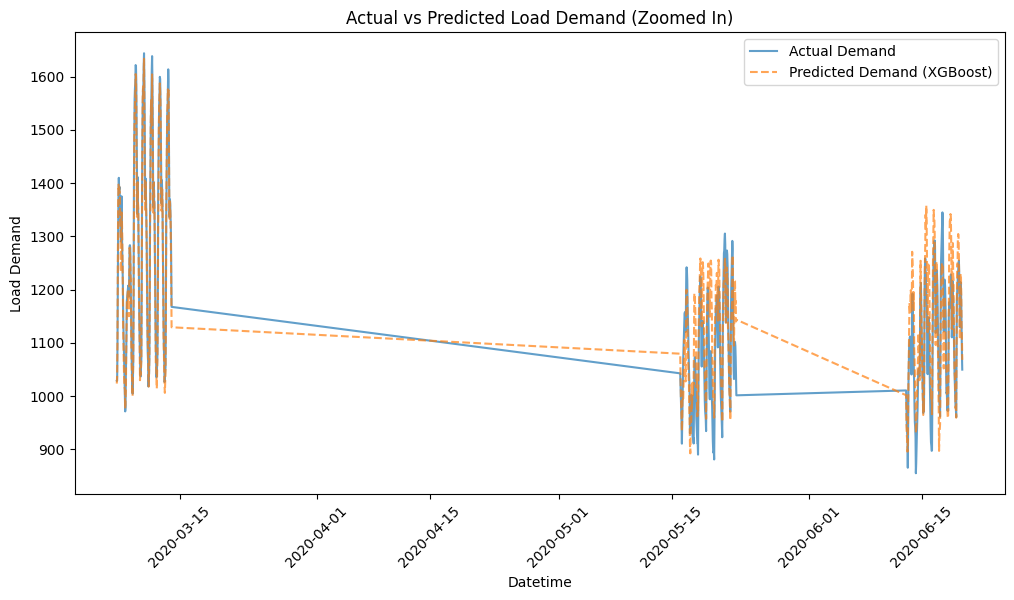

In [26]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#  Ï†ÄÏû•Îêú Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
test_df = pd.read_csv("./archive/final_predictions.csv")

#  Ï†ÄÏû•Îêú Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
best_xgb = joblib.load("./archive/final_xgb_model.pkl")

# datetime Ïª¨ÎüºÏùÑ datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

# XÏ∂ï Î≤îÏúÑÎ•º Ï§ÑÏó¨ ÌôïÎåÄ Ìö®Í≥º Ï†ÅÏö© (ÎßàÏßÄÎßâ 500Í∞ú Îç∞Ïù¥ÌÑ∞Îßå ÏãúÍ∞ÅÌôî)
test_df_zoomed = test_df.iloc[-500:, :]

#  ÏãúÍ∞ÅÌôî: Ïã§Ï†ú Î∂ÄÌïò vs ÏµúÏ¢Ö ÏòàÏ∏°Í∞í ÎπÑÍµê (ÏãúÍ∞Ñ ÌùêÎ¶ÑÏóê Îî∞Î•∏ Î≥ÄÌôî)
plt.figure(figsize=(12, 6))
plt.plot(test_df_zoomed["datetime"], test_df_zoomed["DEMAND"], label="Actual Demand", linestyle="-", alpha=0.7)
plt.plot(test_df_zoomed["datetime"], test_df_zoomed["xgb_optuna_fixed_pred"], label="Predicted Demand (XGBoost)", linestyle="--", alpha=0.7)

# XÏ∂ï Ìè¨Îß∑ Î∞è Í∞ÑÍ≤© Ï°∞Ï†ï
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.xlabel("Datetime")
plt.ylabel("Load Demand")
plt.title("Actual vs Predicted Load Demand")
plt.legend()
plt.show()


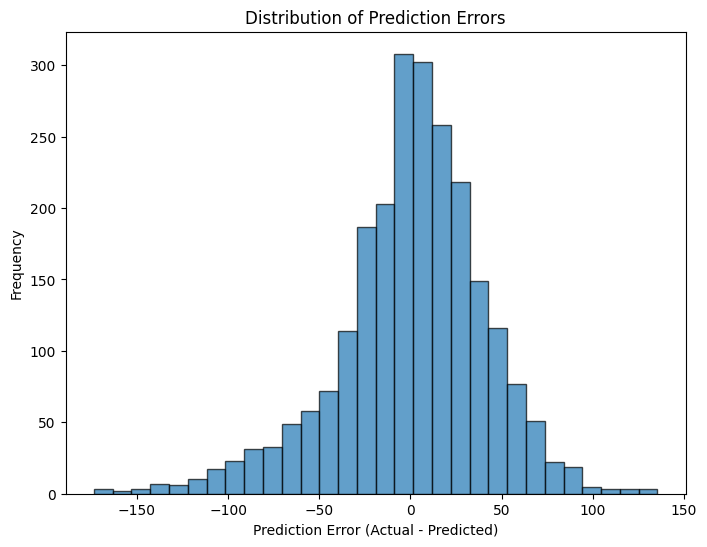

In [31]:
#  ÏãúÍ∞ÅÌôî: ÏòàÏ∏° Ïò§Ï∞® Î∂ÑÌè¨ (ÌûàÏä§ÌÜ†Í∑∏Îû®)
errors = test_df["DEMAND"] - test_df["xgb_optuna_fixed_pred"]
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [28]:
## Î™®Îç∏ Î≥Ñ ÏÑ±Îä• ÎπÑÍµê

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

#  Îç∞Ïù¥ÌÑ∞ Î°úÎî©
train_df = pd.read_csv("./archive/train_data_processed.csv")
test_df = pd.read_csv("./archive/test_data_processed.csv")

#  ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü ÏÑ§Ï†ï
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday",
            "Holiday_ID", "hourOfDay", "T2M_toc", "peak_time", "season"]
target = "DEMAND"

#  ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

#  ÎπÑÍµêÌï† Î™®Îç∏ Ï†ïÏùò
models = {
    "XGBoost": XGBRegressor(**{"n_estimators": 300, "learning_rate": 0.1, "max_depth": 7, "subsample": 0.8, "colsample_bytree": 0.8, "random_state": 42}),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42),
    "Linear Regression": LinearRegression(),
    "MLP (Neural Network)": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
}

#  Î™®Îç∏Î≥Ñ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
results = {}

for name, model in models.items():
    print(f" Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # ÏÑ±Îä• ÌèâÍ∞Ä
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    results[name] = {"MAE": mae, "RMSE": rmse}

# üîπ Í≤∞Í≥º Ï∂úÎ†•
for model, metrics in results.items():
    print(f"‚úÖ {model} - MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}")


üîπ Training XGBoost...
üîπ Training Random Forest...
üîπ Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 465830, number of used features: 12
[LightGBM] [Info] Start training from score 1182.505751
üîπ Training Linear Regression...
üîπ Training MLP (Neural Network)...
‚úÖ XGBoost - MAE: 28.80, RMSE: 38.26
‚úÖ Random Forest - MAE: 36.86, RMSE: 49.51
‚úÖ LightGBM - MAE: 33.41, RMSE: 44.57
‚úÖ Linear Regression - MAE: 47.21, RMSE: 65.43
‚úÖ MLP (Neural Network) - MAE: 37.48, RMSE: 50.51


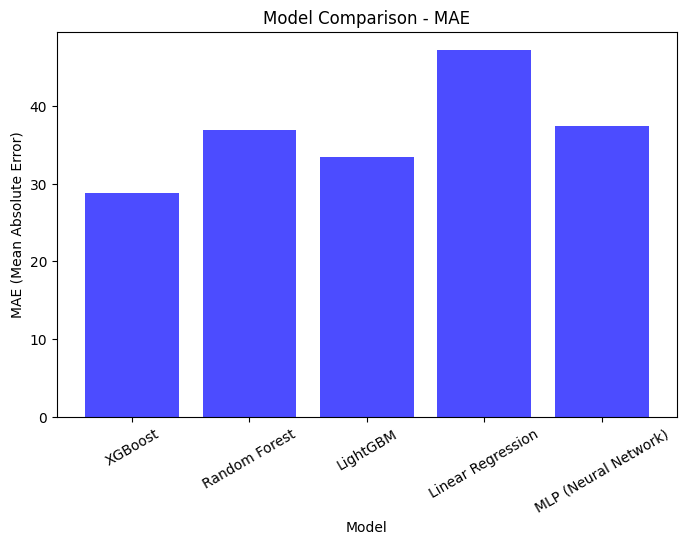

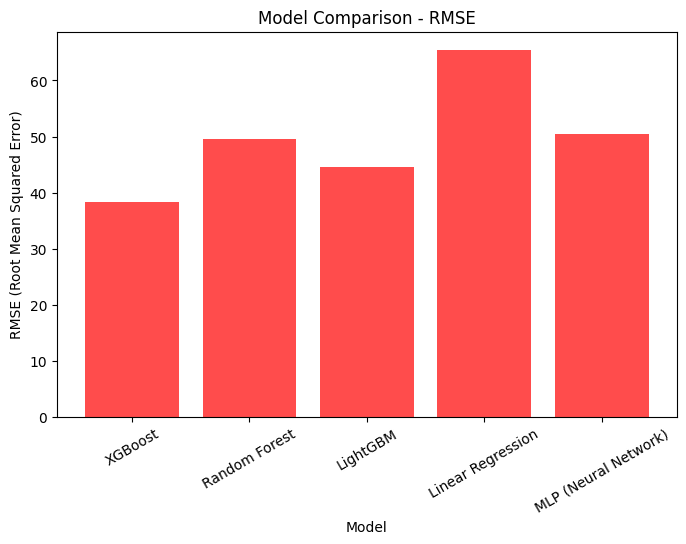

In [29]:
#  ÏãúÍ∞ÅÌôî: Î™®Îç∏Î≥Ñ ÏÑ±Îä• ÎπÑÍµê
mae_values = [results[model]["MAE"] for model in results]
rmse_values = [results[model]["RMSE"] for model in results]
model_names = list(results.keys())

#  MAE ÎπÑÍµê Í∑∏ÎûòÌîÑ
plt.figure(figsize=(8, 5))
plt.bar(model_names, mae_values, color="blue", alpha=0.7)
plt.xlabel("Model")
plt.ylabel("MAE (Mean Absolute Error)")
plt.title("Model Comparison - MAE")
plt.xticks(rotation=30)
plt.show()

#  RMSE ÎπÑÍµê Í∑∏ÎûòÌîÑ
plt.figure(figsize=(8, 5))
plt.bar(model_names, rmse_values, color="red", alpha=0.7)
plt.xlabel("Model")
plt.ylabel("RMSE (Root Mean Squared Error)")
plt.title("Model Comparison - RMSE")
plt.xticks(rotation=30)
plt.show()


ÏÑ±Îä• Í∞úÏÑ† Î∞©Ïïà
ÏµúÍ∑º 7Ïùº Ïù¥Îèô ÌèâÍ∑†(MA_7), ÏµúÍ∑º 14Ïùº Ïù¥Îèô ÌèâÍ∑†(MA_14) Ï∂îÍ∞Ä
‚Üí Ï†ÑÎ†• ÏÇ¨Ïö© Ìå®ÌÑ¥Ïù¥ ÏùºÏ†ï Í∏∞Í∞Ñ ÎèôÏïà Ïú†ÏÇ¨Ìï† Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùå

ÎÇ†Ïî® Î≥ÄÏàò Ï∂îÍ∞Ä (Í∏∞Ïò® + ÏäµÎèÑ + ÌíçÏÜç Í≥†Î†§Ìïú Ï≤¥Í∞ê Ïò®ÎèÑ Ìè¨Ìï®)
‚Üí Ï†ÑÎ†• ÏÇ¨Ïö©ÎüâÏùÄ Ïò®ÎèÑ Î≥ÄÌôîÎøêÎßå ÏïÑÎãàÎùº ÏäµÎèÑÏóêÎèÑ ÏòÅÌñ•ÏùÑ Î∞õÏùå

Stacking Î™®Îç∏ ÌôúÏö© (XGBoost + LGBM + RandomForest ÏïôÏÉÅÎ∏î)
‚Üí Îã§ÏñëÌïú Î™®Îç∏ÏùÑ Í≤∞Ìï©ÌïòÎ©¥ Îçî Ï†ïÍµêÌïú ÏòàÏ∏° Í∞ÄÎä•

ÏãúÍ≥ÑÏó¥Î∂ÑÏÑù LSTM ÎÇòÏ§ëÏóê